# RAGAS Customization의 필요성
## 1 실제 사용자 질의와 ragas 평가용 질의의 간극 해소
* ragas의 기본 데이터 생성 방식은 대부분의 문서에 적용 가능한 범용적인 문서-질의-응답 패턴을 기반으로 설계됨
  * 문서를 통한 페르소나 생성이 아닌 실제 사용자 페르소나 입력을 통해 실제와 가까운 질의 생성
* summary embedding의 유사도를 중심으로 문서를 선택하고 질의를 생성하는 구조적 특성으로 인해 다음과 같은 문제가 발생
  * Multi-Hop 평가 데이터 생성에서 페르소나 생성이나 문서 선택 단계에서 summary embedding을 주로 활용
  * 이로 인해, 동일 키워드에 대한 서로 다른 주제나 테마를 가진 문서들 기반 평가 데이터셋 생성 불가능
  * summary embedding의 값이 유사성으로 인해 single-section의 문서 조합 기반 평가 데이터셋이 주로 나타남남
  * 결과적으로 실제 사용자 질의의 복합적 의도나 문맥적 요구사항을 충분히 반영하지 못하는 한계 발생
  * 질의 예시
    * ex) "**sumo 데드리프트의 마무리 동작에서 허리**에 과도한 무게 집중이 나타나고 있어. 이 현상이 나타나는 **과학적 이유**와 이를 해결하기 위한 **연습 방법**을 작성해줘."
      * 중심 키워드: sumo 데드리프트, 마무리 동작, 허리
      * 주제: 과학적 이유, 연습 방법
    * 이와 같이, 실제 사용자 질의는 단일 키워드에 대한 복합 주제(multi-section) 흐름을 포함하는 경우가 많음.
    * 그러나, RAGAS 기본 데이터 생성 방식은 이를 추분히 반영하지 못함으로, 커스터마이징이 필수

## 2. 변별력 강화를 위한 합성 데이터 설계
* 좋은 평가 데이터는 다양한 RAG 시스템이나 LLM 모델 간의 성능 차이를 명확하게 드러낼 수 있어야 함
* 이는 '변별력'을 지닌 질의로 정의
* Multi-Hop 관련 시나리오 생성 신규 방안 도입을 통해 변별력을 가진 합성 데이터 생성  
* 복합 유형(Simplt + Abstraction)을 통한 변별력 강화
  * ex) "역도 훈련 프로그램 구성에서 일반적인 훈련원칙은 무엇이고, 각 원칙에 대한 근거를 설명해줘."

## RAGAS Customization 확인 절차
1. ragas 기반의 기본 합성 데이터셋 생성
2. 기본 합성 데이터셋 기반 검색 절차의 hyper parameter tuning 진행
3. 검색 성능 평가의 분포를 고려하여 일부 hyper parameter 조합을 선정
4. hyper parameter 조합을 대상으로 생성 절차의 hyper parameter tuning 진행
5. custom 합성 데이터셋 생성
6. custom 합성 데이터셋 기반 검색·생성 절차의 성능 평가
7. 평가지표 비교를 통한 변별력 확인
   * 성능 분산(분포)의 폭 비교
   * 정렬 결과 차이 분석(Rank Sensitivity)
   * 통계적 유의성 테스트

변별력 확인이 어렵다면, 합성 데이터의 점수가 낮은지 높은지를 확인함.

## hyper parameter 관련 주요 설정(auto_rag)
1. 검색 평가 지표: [retrieval_f1, retrieval_ndcg, retrieval_map]
2. bm25 tokenizer: ko_kiwi
3. rrf_k(num_chunk): [3, 5, 10]
4. 생성 평가 지표: bert_score 및 g_eval
   * 여기서 ragas의 주요 지표를 사용해도 좋을거 같음

In [1]:
import os
import json
from tqdm import tqdm

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
with open('../data/document/역도/chunk_with_overlap.json', 'r', encoding='utf-8') as f:
    origin_data = json.load(f)

# 'Ⅲ. 역도경기 기술의 구조와 훈련법', 'Ⅳ. 역도체력의 구조와 훈련법'를 사용
sample_data = origin_data[2] + origin_data[3]
print(len(sample_data))

81


In [3]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

from ragas.testset.graph import KnowledgeGraph
from ragas.testset.graph import Node, NodeType

generator_llm = LangchainLLMWrapper(ChatOpenAI(model='gpt-4o-mini'))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

c:\Users\dbtmd\anaconda3\envs\SportAgent\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from langchain_core.documents import Document

kg = KnowledgeGraph()

for doc in sample_data:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={'page_content': doc['page_content'],
                        'document_metadata': doc['metadata']}
        )
    )

## 1. 문서 기반 페르소나 생성이 아닌 사용자를 대변하는 페르소나 설정
* 실 사용자를 예상하여 페르소나 설정
* 사용자의 운동수준, 신체조건, 관심사항 등을 반영

### 페르소나 목록
1. **일반 피트니스 초보자**: 비운동 경력자이며 건강 및 체력 향상을 위해 역도를 시작함. 쉬운 언어와 안전성에 대한 확신이 필요함.
2. **다이어트 목적의 초보자**: 체형 변화와 체중 감량이 주요 목적이며 체중감량을 위한 루틴 계획에 관심 많음.
3. **홈트레이닝 초보자**: 헬스장을 이용하지 않고 집에서 운동을 시작하려는 사용자. 최소 장비로 가능한 대체 운동에 관심 있음.
4. **중장년 초보자**: 40~60대 이상의 사용자로, 부상 예방과 자세 교정에 민감함.
5. **피트니스 센터 초보자**: 헬스장에서 기초적으로 역도를 시도하는 사용자. 자세와 피드백에 관심 많음..
6. **선수 지망 청소년**: 체육 계열 진학을 준비 중인 청소년. 수치 기반 목표와 경쟁 기준에 민감함.
7. **아마추어 대회 참가자**: 생활체육 대회를 준비하며 감량 및 대회 직전 루틴 계획에 관심 있음.
8. **퍼포먼스 추구자**: 단순 기록 향상보다는 기술 완성도를 추구하며, 운동 역학 기반 피드백을 원함.

In [5]:
from ragas.testset.persona import Persona

persona_general_fitness_beginner = Persona(
    name="General Fitness Beginner",
    role_description="A non-athletic person starting weightlifting for general health or fitness improvement. Needs simple language and assurance about safety.",
)

persona_diet_motivated_beginner = Persona(
    name="Diet-Motivated Beginner",
    role_description="A beginner interested in weightlifting primarily for fat loss and body shaping. Sensitive to body changes and interested in exercise routines.",
)

persona_home_training_beginner = Persona(
    name="Home Training Beginner",
    role_description="Prefers working out at home without going to the gym. Needs alternatives using minimal equipment like dumbbells.",
)

persona_middle_aged_beginner = Persona(
    name="Middle-Aged Beginner",
    role_description="A user aged 40–60+ who is concerned about joint stress and overall health risks. Values injury prevention and correct posture.",
)

persona_fitness_gym_novice = Persona(
    name="Fitness Gym Novice",
    role_description="A gym-goer adding basic weightlifting to their routine. Interested in technique and feedback on form.",
)

persona_youth_athlete_aspirant = Persona(
    name="Youth Athlete Aspirant",
    role_description="A teen preparing for sports school or athlete selection. Seeks performance metrics and competitive standards.",
)

persona_amateur_competitor = Persona(
    name="Amateur Competitor",
    role_description="Trains for amateur lifting competitions. Needs help planning pre-competition routines and managing weight cuts.",
)

persona_performance_optimizer = Persona(
    name="Performance Optimizer",
    role_description="Focuses on technical mastery rather than just numbers. Wants biomechanical insights and detailed feedback.",
)

personas = [persona_general_fitness_beginner,
    persona_diet_motivated_beginner,
    persona_home_training_beginner,
    persona_middle_aged_beginner,
    persona_fitness_gym_novice,
    persona_youth_athlete_aspirant,
    persona_amateur_competitor,
    persona_performance_optimizer,]

## 2. 정보 추출
1) NER 태그
   * 특정 단원이 아닌, 문서 전체에 골고루 배출되어 있는 NER 태그를 선택
   * 사용자 예상 질문과 관련해, 시나리오 구성을 위한 정보 추출
2) Summary + Summary Embedding
   * summary embedding의 유사도 중심의 기존 RAGAS의 합성 데이터 생성 과정 방지를 위해 사용
3) ThemeExtractor
   * persona(사용자 역할)와 theme(주제)를 매칭하여, "이 persona가 이 theme에 대해 궁금할 만한 질문" 인지를 평가하기 위해 사용

### NER 태그 세트 목록
* 운동명(exercise_name)
  * 종목 또는 기술 종목 구분, 세부 운동 이름
  * Snatch, Clean, Jerk, Power Snatch, Front Squat, Snatch Pull 등
* 운동 세부 구간(exercise_phase)
  * Start Position, First Pull, Second Pull, Lockout, Recovery, 1구간, 2구간, 3구간 등
* 신체부위(body_part)
  * 사용하거나 강화하는 근육, 주요 관절, 신체부위명
  * 광배근, 복직근, 대퇴이두근, 무릎 신전, 고관절 굴곡, 발목 신전, 어깨, 무릎, 손목

https://docs.ragas.io/en/latest/howtos/customizations/testgenerator/_testgen-custom-single-hop/

In [ ]:
from pydantic import BaseModel
from typing import List, Tuple, Type, Dict, Any
from dataclasses import dataclass
# from ragas import LLMBasedExtractor, PydanticPrompt, TextWithExtractionLimit, Node
from ragas.testset.transforms.base import LLMBasedExtractor
from ragas.testset.transforms.extractors.llm_based import TextWithExtractionLimit
from ragas.testset.transforms import apply_transforms

class CustomNEROutput(BaseModel):
    exercise_name: List[str]
    exercise_phase: List[str]
    body_part: List[str]

class CustomNERPrompt(PydanticPrompt[TextWithExtractionLimit, CustomNEROutput]):
    instruction: str = (
        "Extract named entities from the given text and classify them into the following three categories:\n\n"
        "1) exercise_name: Names of sports movements or technical weightlifting exercises.\n"
        "   - Example: Snatch, Clean, Jerk, Power Snatch, Front Squat, Snatch Pull\n\n"
        "2) exercise_phase: Specific stages or segments within an exercise movement.\n"
        "   - Example: Start Position, First Pull, Second Pull, Lockout, Recovery, 1구간, 2구간, 3구간\n\n"
        "3) body_part: Related anatomical terms, including muscles, joint actions, and body parts involved in weightlifting movements.\n"
        "   - Example: 광배근, 복직근, 대퇴이두근, quadriceps, hamstrings, wrist extension, hip flexion, knees, shoulders, ankles\n\n"
        "Make sure to accurately classify extracted entities into these categories. "
        "Limit the number of entities extracted per category according to the specified maximum."
    )
    input_model: Type[TextWithExtractionLimit] = TextWithExtractionLimit
    output_model: Type[CustomNEROutput] = CustomNEROutput
    examples: List[Tuple[TextWithExtractionLimit, CustomNEROutput]] = [
        (
            TextWithExtractionLimit(
                text=(
                    "클린 동작의 스타트 포지션에서는 발바닥 전체에 체중을 싣고 대퇴사두근을 활용하여 초반 힘을 전달해야 합니다. "
                    "세컨드 풀에서는 무릎과 고관절을 폭발적으로 펴면서 빠른 속도로 바를 들어올려야 하며, 이 과정에서 훅 그립을 유지하는 것이 중요합니다. "
                    "힙 플렉션과 손목의 안정성은 캐치 구간으로 전환할 때 부드러운 연결을 만들어줍니다. "
                    "최종적으로 팔꿈치를 빠르게 바벨 아래로 밀어넣어 프론트 랙 자세를 완성해야 합니다."
                ),
                max_num=15,
            ),
            CustomNEROutput(
                exercise_name=["클린"],
                exercise_phase=["스타트 포지션", "세컨드 풀", "캐치 구간"],
                body_part=["대퇴사두근", "무릎", "고관절", "힙 플렉션", "손목", "팔꿈치"],
            ),
        ),
        (
            TextWithExtractionLimit(
                text=(
                    "파워 스내치를 연습할 때는 스타트 포지션에서 어깨를 바벨보다 약간 앞쪽에 두고 등을 고정시킨 채 시작해야 합니다. "
                    "퍼스트 풀에서는 햄스트링과 둔근을 주로 사용하며, 무릎, 발목, 고관절을 동시에 확장하는 동작이 중요합니다. "
                    "익스텐션 페이즈에서는 최대 힘을 내어 바벨을 수직으로 밀어올리고, 락아웃에서는 팔꿈치를 완전히 펴고 손목 안정성을 확보하여 "
                    "바를 머리 위에 고정해야 합니다. 전신 후면 사슬의 긴장 유지가 퍼포먼스를 좌우합니다."
                ),
                max_num=15,
            ),
            CustomNEROutput(
                exercise_name=["파워 스내치"],
                exercise_phase=["스타트 포지션", "퍼스트 풀", "익스텐션 페이즈", "락아웃"],
                body_part=["어깨", "등", "햄스트링", "둔근", "무릎", "발목", "고관절", "팔꿈치", "손목", "후면 사슬"],
            )
        ),
        (
            TextWithExtractionLimit(
                text=(
                    "세컨드 풀 단계에서는 고관절과 무릎의 강력한 신전이 필요합니다. "
                    "동시에 발목 플랜타플렉션이 일어나며 몸 전체가 수직 방향으로 힘을 전달하게 됩니다. "
                    "어깨와 손목의 안정성이 유지되어야 바벨과 몸의 중심이 일치할 수 있습니다."
                ),
                max_num=15,
            ),
            CustomNEROutput(
                exercise_name=[],
                exercise_phase=["세컨드 풀"],
                body_part=["고관절", "무릎", "발목 플랜타플렉션", "어깨", "손목"],
            ),
        )
    ]


@dataclass
class CustomERExtractor(LLMBasedExtractor):
    """
    Extracts entities in three categories: exercise_name, exercise_phase, body_part.
    """
    property_name: str = "exercise_entities"
    prompt: PydanticPrompt[TextWithExtractionLimit, CustomNEROutput] = CustomNERPrompt()
    max_num_entities: int = 10  # per category

    async def extract(self, node: Node) -> Dict[str, List[str]]:
        heading = '\n'.join([item for key, item in node.properties['document_metadata']['heading'].items() if not item is None])
        node_text = node.get_property("page_content") or ""
        text = heading + '\n' + node_text

        all_entities: Dict[str, List[str]] = {
            "exercise_name": [],
            "exercise_phase": [],
            "body_part": [],
        }

        if node_text == "":
            # node.properties[self.property_name] == all_entities
            return self.property_name, all_entities

        result: CustomNEROutput = await self.prompt.generate(
            self.llm,
            data=TextWithExtractionLimit(
                text=text,
                max_num=self.max_num_entities
            ),
        )
        all_entities["exercise_name"].extend(result.exercise_name)
        all_entities["exercise_phase"].extend(result.exercise_phase)
        all_entities["body_part"].extend(result.body_part)

        # node.properties[self.property_name] == all_entities
        return self.property_name, all_entities

NameError: name 'PydanticPrompt' is not defined

In [68]:
from langchain_openai import ChatOpenAI
from ragas.llms import LangchainLLMWrapper
from ragas.testset.transforms import apply_transforms

from ragas.testset.transforms.extractors.embeddings import EmbeddingExtractor
from ragas.testset.transforms.extractors.llm_based import (
    SummaryExtractor,
    ThemesExtractor
)

llm = LangchainLLMWrapper(ChatOpenAI())

customNer_extractor = CustomERExtractor(llm=generator_llm)
summary_extractor = SummaryExtractor(llm=llm)
themes_extractor = ThemesExtractor(llm=llm)
embedding_extractor = EmbeddingExtractor(
    embedding_model=generator_embeddings,
    property_name="summary_embedding",
    embed_property_name="summary",
    filter_nodes=lambda node: node.get_property("summary") is not None
)

transforms = [
    customEr_extractor,
    themes_extractor,
    summary_extractor,
    embedding_extractor
]

# apply_transforms(kg, transforms=transforms)
# kg.save('../data/document/역도/kg_sector3_4_custom_no_relation.json')

Applying CustomNERExtractor:   0%|          | 0/81 [00:00<?, ?it/s]

Property 'exercise_entities' already exists in node 'eb21ff'. Skipping!
Applying CustomNERExtractor:   4%|▎         | 3/81 [00:01<00:35,  2.17it/s]Property 'exercise_entities' already exists in node 'd1caee'. Skipping!
Property 'exercise_entities' already exists in node 'e7bcf9'. Skipping!
Applying CustomNERExtractor:   9%|▊         | 7/81 [00:02<00:14,  5.27it/s]Property 'exercise_entities' already exists in node '659aad'. Skipping!
Property 'exercise_entities' already exists in node '2c0334'. Skipping!
Applying CustomNERExtractor:  16%|█▌        | 13/81 [00:02<00:08,  8.26it/s]Property 'exercise_entities' already exists in node '84a1e9'. Skipping!
Property 'exercise_entities' already exists in node 'eb4433'. Skipping!
Applying CustomNERExtractor:  19%|█▊        | 15/81 [00:02<00:06,  9.51it/s]Property 'exercise_entities' already exists in node 'f7f9c9'. Skipping!


In [87]:
kg = KnowledgeGraph.load('../data/document/역도/kg_sector3_4_custom_no_relation.json')

In [88]:
kg.nodes[80].properties['exercise_entities']

{'exercise_name': ['백 스쿼트', '하프 스쿼트'],
 'exercise_phase': [],
 'body_part': ['대둔근', '햄스트링', '대퇴사두근']}

## 3. 관계형성
* RAGAS에서 제공하는 NER 기반의 관계형성 방법인 OverlapScoreBuilder를 변형해, 서로 다른 section간 연결 증대
  * 개체명 정규화, 기존 get_noisy_item(자주 등장하는 엔티티 필터링) 기능 제거
  * 기존 알고리즘 대비 관계수 ()% 증가

### 기존 OverlapScoreBuilder
* exercise_name: 327 개
* exercise_phase: 255 개
* body_part: 1256개
* 총 1838 개
* 

In [89]:
from copy import copy 

kg_copy = copy(kg)
print(kg_copy)

KnowledgeGraph(nodes: 81, relationships: 0)


In [90]:
import typing as t
from collections import Counter
from dataclasses import dataclass

from ragas.testset.graph import KnowledgeGraph, Node, Relationship
from ragas.testset.transforms.base import RelationshipBuilder

@dataclass
class OverlapScoreBuilder(RelationshipBuilder):
    property_name: str = "entities"
    key_name: t.Optional[str] = None
    new_property_name: str = "overlap_score"
    distance_measure: DistanceMeasure = DistanceMeasure.JARO_WINKLER
    distance_threshold: float = 0.9
    threshold: float = 0.01

    def __post_init__(self):
        try:
            from rapidfuzz import distance
        except ImportError:
            raise ImportError(
                "rapidfuzz is required for string distance. Please install it using `pip install rapidfuzz`"
            )

        self.distance_measure_map = {
            DistanceMeasure.LEVENSHTEIN: distance.Levenshtein,
            DistanceMeasure.HAMMING: distance.Hamming,
            DistanceMeasure.JARO: distance.Jaro,
            DistanceMeasure.JARO_WINKLER: distance.JaroWinkler,
        }

    def _overlap_score(self, overlaps: t.List[bool]) -> float:

        return sum(overlaps) / len(overlaps) if len(overlaps) > 0 else 0.0

    def _get_noisy_items(
        self, nodes: t.List[Node], property_name: str, percent_cut_off: float = 0.05
    ) -> t.List[str]:

        all_items = []
        for node in nodes:
            items = node.get_property(property_name)
            if items is not None:
                if isinstance(items, str):
                    all_items.append(items)
                elif isinstance(items, list):
                    all_items.extend(items)
                else:
                    pass

        num_unique_items = len(set(all_items))
        num_noisy_items = max(1, int(num_unique_items * percent_cut_off))
        noisy_list = list(dict(Counter(all_items).most_common()).keys())[
            :num_noisy_items
        ]
        return noisy_list

    async def transform(self, kg: KnowledgeGraph) -> t.List[Relationship]:
        if self.property_name is None:
            self.property_name

        distance_measure = self.distance_measure_map[self.distance_measure]
        noisy_items = self._get_noisy_items(kg.nodes, self.property_name)
        relationships = []
        for i, node_x in enumerate(kg.nodes):
            for j, node_y in enumerate(kg.nodes):
                if i >= j:
                    continue
                node_x_items = node_x.get_property(self.property_name)
                node_y_items = node_y.get_property(self.property_name)
                if node_x_items is None or node_y_items is None:
                    raise ValueError(
                        f"Node {node_x.id} or {node_y.id} has no {self.property_name}"
                    )
                if self.key_name is not None:
                    node_x_items = node_x_items.get(self.key_name, [])
                    node_y_items = node_y_items.get(self.key_name, [])

                overlaps = []
                overlapped_items = []
                for x in node_x_items:
                    if x not in noisy_items:
                        for y in node_y_items:
                            if y not in noisy_items:
                                similarity = 1 - distance_measure.distance(
                                    x.lower(), y.lower()
                                )
                                verdict = similarity >= self.distance_threshold
                                overlaps.append(verdict)
                                if verdict:
                                    overlapped_items.append((x, y))

                similarity = self._overlap_score(overlaps)
                if similarity >= self.threshold:
                    relationships.append(
                        Relationship(
                            source=node_x,
                            target=node_y,
                            type=f"{self.property_name}_{self.key_name}_overlap",
                            properties={
                                f"{self.property_name}_{self.new_property_name}": similarity,
                                "overlapped_items": overlapped_items,
                            },
                        )
                    )

        return relationships

In [91]:
exercise_name_overlap_sim = OverlapScoreBuilder(
    property_name='exercise_entities',
    key_name='exercise_name',
    distance_measure=DistanceMeasure.JARO_WINKLER,
    distance_threshold=0.9,
    threshold=0.01
)

exercise_phase_overlap_sim = OverlapScoreBuilder(
    property_name='exercise_entities',
    key_name='exercise_phase',
    distance_measure=DistanceMeasure.JARO_WINKLER,
    distance_threshold=0.9,
    threshold=0.01
)

body_part_overlap_sim = OverlapScoreBuilder(
    property_name='exercise_entities',
    key_name='body_part',
    distance_measure=DistanceMeasure.JARO_WINKLER,
    distance_threshold=0.9,
    threshold=0.01
)

transforms = [
    exercise_name_overlap_sim,
    exercise_phase_overlap_sim,
    body_part_overlap_sim
]

apply_transforms(kg_copy, transforms=transforms)

In [100]:
count_relation = {'exercise_name': 0,
                  'exercise_phase': 0,
                  'body_part': 0}

for relation in kg_copy.relationships:
    count_relation['_'.join(relation.type.split('_')[2: -1])] += 1

print(count_relation)
print(sum(count_relation.values()))

{'exercise_name': 327, 'exercise_phase': 255, 'body_part': 1256}
1838


### exercise_eneities의 category별 분포 현황

In [32]:
from tqdm import tqdm

def get_distribution(kg, category):
    category_count_before = {}
    category_count_after = {}
    num_document = 0

    for node in kg.nodes:
        entities = node.properties['exercise_entities'][category]
        if entities != []:
            num_document += 1

        for entity in entities:
            if entity in category_count_before:
                category_count_before[entity] += 1
            else:
                category_count_before[entity] = 1

            entity_lower = entity.lower()
            if entity_lower in category_count_after:
                category_count_after[entity_lower] += 1
            else:
                category_count_after[entity_lower] = 1

    category_count_before = sorted(category_count_before.items(), key = lambda x : x[1], reverse=True)
    category_count_after = sorted(category_count_after.items(), key = lambda x : x[1], reverse=True)
    
    return category_count_before, category_count_after, num_document


In [33]:
category_count_before, category_count_after, num_document = get_distribution(kg, 'exercise_name')

In [37]:
print(len(category_count_before))
print(category_count_before)

88
[('인상', 20), ('용상', 13), ('클린', 7), ('저크', 7), ('Jerk', 6), ('잡아채기', 5), ('스내치', 3), ('Snatch', 3), ('Clean and Jerk', 3), ('Clean', 3), ('앉아받기', 2), ('Jerk Dip', 2), ('Jerk Up', 2), ('Jerk Split', 2), ('High Clean from Hang', 2), ('Top Clean', 2), ('Jerk Balance', 2), ('Split Jerk Balance', 2), ('Clean Deadlift', 2), ('박스 푸시업', 2), ('Forward Lunge', 2), ('리프팅', 1), ('컬', 1), ('파워리프팅', 1), ('훅그립', 1), ('Squat Snatch', 1), ('Split Snatch', 1), ('끌기', 1), ('블록', 1), ('스쿼트 스내치', 1), ('클린동작', 1), ('구름동작', 1), ('올림동작', 1), ('jerk Split', 1), ('jerk Off', 1), ('Jerk Recovery', 1), ('Jerk Off', 1), ('Squat', 1), ('인상기술', 1), ('snatch', 1), ('끌기자세', 1), ('이중 굽힘', 1), ('Power Snatch', 1), ('High Snatch', 1), ('High Snatch from Hang', 1), ('Jump Snatch', 1), ('Top Snatch', 1), ('Snatch Dead Lift (T-box)', 1), ('Snatch Dead Lift (block)', 1), ('Snatch Balance', 1), ('Dipping Snatch Balance', 1), ('Power Clean', 1), ('High Clean', 1), ('High Clean (off blocks)', 1), ('One Hand Clean', 1), ('Jum

In [38]:
print(len(category_count_after))
print(category_count_after)

85
[('인상', 20), ('용상', 13), ('클린', 7), ('저크', 7), ('jerk', 6), ('잡아채기', 5), ('snatch', 4), ('스내치', 3), ('jerk split', 3), ('clean and jerk', 3), ('clean', 3), ('앉아받기', 2), ('jerk off', 2), ('jerk dip', 2), ('jerk up', 2), ('high clean from hang', 2), ('top clean', 2), ('jerk balance', 2), ('split jerk balance', 2), ('clean deadlift', 2), ('박스 푸시업', 2), ('forward lunge', 2), ('리프팅', 1), ('컬', 1), ('파워리프팅', 1), ('훅그립', 1), ('squat snatch', 1), ('split snatch', 1), ('끌기', 1), ('블록', 1), ('스쿼트 스내치', 1), ('클린동작', 1), ('구름동작', 1), ('올림동작', 1), ('jerk recovery', 1), ('squat', 1), ('인상기술', 1), ('끌기자세', 1), ('이중 굽힘', 1), ('power snatch', 1), ('high snatch', 1), ('high snatch from hang', 1), ('jump snatch', 1), ('top snatch', 1), ('snatch dead lift (t-box)', 1), ('snatch dead lift (block)', 1), ('snatch balance', 1), ('dipping snatch balance', 1), ('power clean', 1), ('high clean', 1), ('high clean (off blocks)', 1), ('one hand clean', 1), ('jump clean (on disk)', 1), ('wide grip clean', 1), ('j

In [53]:
category_count_before, category_count_after, num_document = get_distribution(kg, 'exercise_phase')

In [54]:
category_count_before

[('시작자세', 12),
 ('Jerk Up', 6),
 ('시작 자세', 6),
 ('준비 자세', 6),
 ('Jerk Dip', 5),
 ('일어서기', 4),
 ('끌기자세', 4),
 ('1국면', 4),
 ('첫 번째 단계', 4),
 ('두 번째 단계', 4),
 ('세 번째 단계', 4),
 ('무릎높이까지 끌기', 3),
 ('앉아받기', 3),
 ('Jerk 시작', 3),
 ('Recovery', 3),
 ('2국면', 3),
 ('예비자세', 3),
 ('1구간', 3),
 ('끌기구간', 3),
 ('앉아받기 구간', 3),
 ('바 내리기', 2),
 ('클린 시작자세', 2),
 ('앉아받기 자세', 2),
 ('3국면', 2),
 ('4국면', 2),
 ('준비동작', 2),
 ('마지막 단계', 2),
 ('2구간', 2),
 ('바벨 들어 올리기', 2),
 ('일어서기 구간', 2),
 ('중간 단계', 2),
 ('스타트자세', 1),
 ('출발 자세', 1),
 ('무릎높이까지 들어올리기', 1),
 ('몸통 완전히 펴기', 1),
 ('앉아 받기', 1),
 ('자세 고정하기', 1),
 ('정적인 시작', 1),
 ('예비동작', 1),
 ('전체적인 동작', 1),
 ('몸통 펴고 잡아채기', 1),
 ('상방으로 발목이 최대로 들린 동작', 1),
 ('마지막 풀', 1),
 ('동작이 끝나고', 1),
 ('정점에서', 1),
 ('하방으로 빠른 앉아 받기', 1),
 ('무릎 구간', 1),
 ('몸통 펴기 구간', 1),
 ('준비자세', 1),
 ('앉아 받기 전까지', 1),
 ('앉아 받기-일어서기', 1),
 ('끌기 자세', 1),
 ('몸통 펴고 잡아채기 자세', 1),
 ('끌기 동작', 1),
 ('이중 굽힘 동작', 1),
 ('앉아받기 전 단계', 1),
 ('일어서기 전 단계', 1),
 ('앉아받기 동작', 1),
 ('Jerk start', 1),
 ('Jerk Split', 1),
 

In [55]:
category_count_after

[('시작자세', 12),
 ('jerk up', 6),
 ('시작 자세', 6),
 ('준비 자세', 6),
 ('jerk dip', 5),
 ('일어서기', 4),
 ('끌기자세', 4),
 ('1국면', 4),
 ('첫 번째 단계', 4),
 ('두 번째 단계', 4),
 ('세 번째 단계', 4),
 ('무릎높이까지 끌기', 3),
 ('앉아받기', 3),
 ('jerk 시작', 3),
 ('recovery', 3),
 ('2국면', 3),
 ('예비자세', 3),
 ('1구간', 3),
 ('끌기구간', 3),
 ('앉아받기 구간', 3),
 ('바 내리기', 2),
 ('클린 시작자세', 2),
 ('앉아받기 자세', 2),
 ('3국면', 2),
 ('4국면', 2),
 ('준비동작', 2),
 ('마지막 단계', 2),
 ('2구간', 2),
 ('바벨 들어 올리기', 2),
 ('일어서기 구간', 2),
 ('중간 단계', 2),
 ('스타트자세', 1),
 ('출발 자세', 1),
 ('무릎높이까지 들어올리기', 1),
 ('몸통 완전히 펴기', 1),
 ('앉아 받기', 1),
 ('자세 고정하기', 1),
 ('정적인 시작', 1),
 ('예비동작', 1),
 ('전체적인 동작', 1),
 ('몸통 펴고 잡아채기', 1),
 ('상방으로 발목이 최대로 들린 동작', 1),
 ('마지막 풀', 1),
 ('동작이 끝나고', 1),
 ('정점에서', 1),
 ('하방으로 빠른 앉아 받기', 1),
 ('무릎 구간', 1),
 ('몸통 펴기 구간', 1),
 ('준비자세', 1),
 ('앉아 받기 전까지', 1),
 ('앉아 받기-일어서기', 1),
 ('끌기 자세', 1),
 ('몸통 펴고 잡아채기 자세', 1),
 ('끌기 동작', 1),
 ('이중 굽힘 동작', 1),
 ('앉아받기 전 단계', 1),
 ('일어서기 전 단계', 1),
 ('앉아받기 동작', 1),
 ('jerk start', 1),
 ('jerk split', 1),
 

In [56]:
num_document

54

In [57]:
category_count_before, category_count_after, num_document = get_distribution(kg, 'body_part')

In [58]:
category_count_before

[('무릎', 38),
 ('어깨', 28),
 ('고관절', 15),
 ('몸통', 14),
 ('발목', 13),
 ('팔꿈치', 13),
 ('팔', 12),
 ('발', 10),
 ('바벨', 9),
 ('엉덩이', 8),
 ('다리', 7),
 ('등', 7),
 ('발바닥', 7),
 ('허리', 6),
 ('머리', 6),
 ('대퇴', 6),
 ('가슴', 6),
 ('이두근', 5),
 ('대퇴사두근', 5),
 ('승모근', 4),
 ('발뒤꿈치', 4),
 ('상체', 4),
 ('상체근력', 4),
 ('상완근', 4),
 ('완요골근', 4),
 ('햄스트링', 4),
 ('손목', 3),
 ('대퇴부', 3),
 ('대둔근', 3),
 ('손', 2),
 ('하지', 2),
 ('정강이', 2),
 ('척추', 2),
 ('둔부', 2),
 ('두 발', 2),
 ('골반', 2),
 ('발가락', 2),
 ('대흉근', 2),
 ('전삼각근', 2),
 ('상완삼두근', 2),
 ('능형근', 2),
 ('광배근', 2),
 ('손바닥', 1),
 ('엄지손가락', 1),
 ('집게손가락', 1),
 ('가운데 손가락', 1),
 ('중족족지관절', 1),
 ('발끝', 1),
 ('어깨관절', 1),
 ('근력', 1),
 ('목 근육', 1),
 ('허벅지', 1),
 ('경골', 1),
 ('하지 신전력', 1),
 ('척골', 1),
 ('턱', 1),
 ('하지 관절', 1),
 ('어깨상지대', 1),
 ('대퇴부 후면', 1),
 ('종아리', 1),
 ('다리근력', 1),
 ('하지관절', 1),
 ('두 팔', 1),
 ('엉덩이관절', 1),
 ('양발', 1),
 ('근육', 1),
 ('두 다리', 1),
 ('앞다리', 1),
 ('신체관절', 1),
 ('발목관절', 1),
 ('다리 근력', 1),
 ('허리근육', 1),
 ('하체', 1),
 ('하지근력', 1),
 ('몸', 1),
 ('자세 변화'

In [59]:
category_count_after

[('무릎', 38),
 ('어깨', 28),
 ('고관절', 15),
 ('몸통', 14),
 ('발목', 13),
 ('팔꿈치', 13),
 ('팔', 12),
 ('발', 10),
 ('바벨', 9),
 ('엉덩이', 8),
 ('다리', 7),
 ('등', 7),
 ('발바닥', 7),
 ('허리', 6),
 ('머리', 6),
 ('대퇴', 6),
 ('가슴', 6),
 ('이두근', 5),
 ('대퇴사두근', 5),
 ('승모근', 4),
 ('발뒤꿈치', 4),
 ('상체', 4),
 ('상체근력', 4),
 ('상완근', 4),
 ('완요골근', 4),
 ('햄스트링', 4),
 ('손목', 3),
 ('대퇴부', 3),
 ('대둔근', 3),
 ('손', 2),
 ('하지', 2),
 ('정강이', 2),
 ('척추', 2),
 ('둔부', 2),
 ('두 발', 2),
 ('골반', 2),
 ('발가락', 2),
 ('대흉근', 2),
 ('전삼각근', 2),
 ('상완삼두근', 2),
 ('능형근', 2),
 ('광배근', 2),
 ('손바닥', 1),
 ('엄지손가락', 1),
 ('집게손가락', 1),
 ('가운데 손가락', 1),
 ('중족족지관절', 1),
 ('발끝', 1),
 ('어깨관절', 1),
 ('근력', 1),
 ('목 근육', 1),
 ('허벅지', 1),
 ('경골', 1),
 ('하지 신전력', 1),
 ('척골', 1),
 ('턱', 1),
 ('하지 관절', 1),
 ('어깨상지대', 1),
 ('대퇴부 후면', 1),
 ('종아리', 1),
 ('다리근력', 1),
 ('하지관절', 1),
 ('두 팔', 1),
 ('엉덩이관절', 1),
 ('양발', 1),
 ('근육', 1),
 ('두 다리', 1),
 ('앞다리', 1),
 ('신체관절', 1),
 ('발목관절', 1),
 ('다리 근력', 1),
 ('허리근육', 1),
 ('하체', 1),
 ('하지근력', 1),
 ('몸', 1),
 ('자세 변화'

In [60]:
num_document

71

In [ ]:
from ragas.testset.transforms.relationship_builders import OverlapScoreBuilder
from ragas.metrics._string import DistanceMeasure

exercise_name_overlap_sim = OverlapScoreBuilder(
    property_name='excercise_entities',
    key_name='exercise_name',
    distance_measure=DistanceMeasure.JARO_WINKLER,
    distance_threshold=0.9,
    threshold=0.01
)

exercise_phase_overlap_sim = OverlapScoreBuilder(
    property_name='excercise_entities',
    key_name='exercise_phase',
    distance_measure=DistanceMeasure.JARO_WINKLER,
    distance_threshold=0.9,
    threshold=0.01
)

body_part_overlap_sim = OverlapScoreBuilder(
    property_name='excercise_entities',
    key_name='body_part',
    distance_measure=DistanceMeasure.JARO_WINKLER,
    distance_threshold=0.9,
    threshold=0.01
)



# RAGAS Customization 방안
## 1. 페르소나 생성 
## 2. 사용자 맞춤 Entity 추출
## 3. 현실적인 질의 시나리오 구성

# RAGAS Customization 결과


## 1. 지식 그래프 구축
### 1) 정보 추출
* 기존
  - Summary Extractor
  - ThemesAndConceptsExtractor
  - NERExtractor
* 개선
  - hierarchical NERExtractor
  - 
### 2) 관계 구축
* 
## 2. 시나리오 생성
## 3. 데이터셋 구축

## 1) 정보 추출
https://docs.ragas.io/en/latest/howtos/customizations/testgenerator/_testgen-custom-single-hop/

In [ ]:
from ragas.testset.graph import KnowledgeGraph
from ragas.testset.graph import Node, NodeType


kg = KnowledgeGraph()
for doc in section01:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={
                "page_content": doc['page_content'],
                "document_metadata": doc['metadata'],
            },
        )
    )

In [ ]:
from langchain_openai import ChatOpenAI
from ragas.llms import LangchainLLMWrapper
from ragas.testset.transforms import apply_transforms

from ragas.testset.transforms.extractors.llm_based import (
    NERExtractor,
    SummaryExtractor
)

llm = LangchainLLMWrapper(ChatOpenAI())

ner_extractor = NERExtractor(llm=llm)
summary_extractor = SummaryExtractor(llm=llm)

transforms = [
    ner_extractor,
    summary_extractor
]

apply_transforms(kg, transforms=transforms)

In [1]:
kg.nodes[0].properties.keys()

NameError: name 'kg' is not defined

In [47]:
def count_numbers_in_intervals(numbers, unit):
    # 최대값을 구함
    max_val = max(numbers)
    
    # 결과를 저장할 딕셔너리
    result = {}
    
    # 0부터 시작하여 각 구간에 대해 숫자 개수를 셈
    start = 0
    while start <= max_val:
        end = start + unit
        count = sum(start <= num < end for num in numbers)
        result[f"{start}-{end}"] = count
        start = end
    
    return result

In [50]:
import pandas as pd

tokens = [document['metadata']['num_tokens'] for document in data['merged_dataset']]
result = count_numbers_in_intervals(tokens, 100)
pd.DataFrame(result, index=[0])


,0-100,100-200,200-300,300-400,400-500,500-600,600-700,700-800,800-900,900-1000,1000-1100,1100-1200,1200-1300,1300-1400,1400-1500,1500-1600,1600-1700,1700-1800,1800-1900,1900-2000,2000-2100,2100-2200,2200-2300,2300-2400,2400-2500,2500-2600,2600-2700,2700-2800,2800-2900,2900-3000,3000-3100,3100-3200,3200-3300,3300-3400,3400-3500,3500-3600,3600-3700,3700-3800,3800-3900,3900-4000
0,18,21,16,40,12,12,16,18,20,16,6,9,10,8,6,6,5,5,4,3,5,3,4,2,1,4,0,0,1,0,0,1,1,0,0,0,1,0,1,1


In [37]:
import tiktoken

encoding = tiktoken.get_encoding('cl100k_base')
for i in range(len(data['merged_dataset'])):
    data['merged_dataset'][i]['metadata']['num_tokens'] = len(encoding.encode(data['merged_dataset'][i]['page_content']))


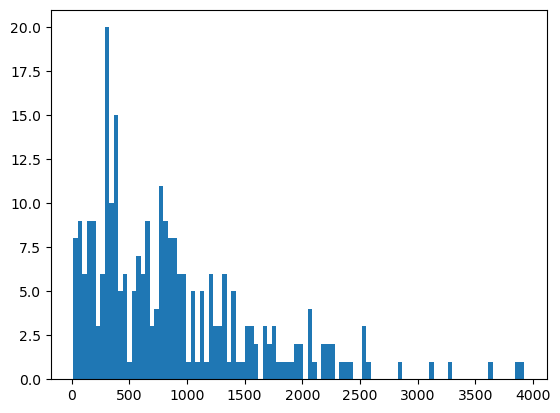

In [17]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from ragas.testset.persona import Persona

gennerator_llm = LangchainLLMWrapper(ChatOpenAI(model='gpt-4o-mini'))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [18]:
personas = [
    Persona(
        name="aspiring coach",
        role_description="A university student majoring in physical education who wants to become a weightlifting coach",
    ), # 체육교육을 전공하며 역도 지도자를 꿈꾸는 대학생

    Persona(
        name="high school athlete",
        role_description="A high school student training for national weightlifting competitions",
    ), # 전국 대회를 준비 중인 고등학생 역도 선수

    Persona(
        name="beginner lifter",
        role_description="Someone new to weightlifting looking for basic guidance on form and training routines",
    ), # 역도를 처음 시작하며 기본 자세와 훈련법을 찾는 초보자

    Persona(
        name="elite coach",
        role_description="A professional coach training elite or semi-professional weightlifters",
    ), # 엘리트 또는 준프로 선수를 지도하는 전문 코치

    Persona(
        name="rehab specialist",
        role_description="A rehabilitation therapist studying how weightlifting can aid physical recovery",
    ), # 역도를 재활 프로그램에 활용하려는 치료사

    Persona(
        name="sport scientist",
        role_description="A researcher interested in the biomechanics and physiology of weightlifting",
    ), # 역도의 생체역학과 생리학을 연구하는 스포츠 과학자

    Persona(
        name="youth coach",
        role_description="A coach focused on developing proper techniques in young weightlifters",
    ), # 청소년 선수의 올바른 기술 습득을 지도하는 코치

    Persona(
        name="strength trainer",
        role_description="A personal trainer using weightlifting to help clients build strength",
    ), # 역도를 통해 근력을 키워주는 퍼스널 트레이너

    Persona(
        name="PE teacher",
        role_description="A physical education teacher integrating weightlifting into school curriculum",
    ), # 학교 수업에 역도를 접목하려는 체육 교사

    Persona(
        name="female athlete",
        role_description="A female athlete looking for gender-specific guidance in weightlifting",
    ), # 여성 특화 역도 지도를 원하는 여성 선수

    Persona(
        name="injury-prone lifter",
        role_description="An athlete with a history of injuries seeking safe lifting practices",
    ), # 부상 경력이 있어 안전한 역도 기술을 찾는 운동선수

    Persona(
        name="fitness influencer",
        role_description="A content creator looking to produce accurate, educational weightlifting videos",
    ), # 정확하고 교육적인 역도 콘텐츠를 만들고자 하는 피트니스 인플루언서

    Persona(
        name="sports admin",
        role_description="A sports policy maker or administrator developing youth weightlifting programs",
    ), # 청소년 역도 프로그램을 기획하는 체육 행정가

    Persona(
        name="club manager",
        role_description="A local gym or weightlifting club manager seeking structured training programs",
    ), # 체계적인 훈련 프로그램을 찾는 지역 헬스장 혹은 역도 클럽 관리자

    Persona(
        name="talent scout",
        role_description="A scout identifying and nurturing young weightlifting talent",
    ), # 유망한 역도 선수를 발굴하고 육성하는 스카우트
]

In [ ]:
tmp_persona = personas[:3]
tmp_data = data['new_dataset'][3]

In [ ]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

In [29]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlineSplitter:   0%|          | 0/32 [00:00<?, ?it/s]           unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to ap

In [33]:
dataset_df = dataset.to_pandas()

In [38]:
dataset_df

,user_input,reference_contexts,reference,synthesizer_name
0,일본이 한국 역도에 미친 영향은 무엇인가요?,[1926년 이전의 우리나라 역도는 한일합방(1910년) 이후 각 학교에 부임해 온...,"일본은 1926년 이전 한국의 역도에 규깡과 아령, 철봉운동 등을 소개하며 영향을 ...",single_hop_specifc_query_synthesizer
1,남수일의 세계신기록 세운 연도는 언제인가요?,[1926년 이전의 우리나라 역도는 한일합방(1910년) 이후 각 학교에 부임해 온...,남수일은 1938년 10월의 제3회 일본선수권대회에서 60㎏급 인상과 추상에서 31...,single_hop_specifc_query_synthesizer
2,1926년 이후 한국의 역도 발전은 어떻게 이루어졌나요?,[1926년 이전의 우리나라 역도는 한일합방(1910년) 이후 각 학교에 부임해 온...,1926년 이후 우리나라 역도는 비록 일본 말을 그대로 따온 규정에서 비롯되었지만 ...,single_hop_specifc_query_synthesizer
3,바르셀로나 올림픽에서 한국 역도 선수의 성과는 어땠나요?,"[한국 역도의 황금기였다고 할 수 있는데, 이후 국제 스포 츠 정보에 민감하게 대응...",1992년 바르셀로나 올림픽경기대회에서 한국역도사상 처음으로 56㎏급의 전병관이 금...,single_hop_specifc_query_synthesizer
4,장미란 선수는 한국 역도 역사에서 어떤 중요한 성과를 이루었나요?,"[한국 역도의 황금기였다고 할 수 있는데, 이후 국제 스포 츠 정보에 민감하게 대응...",장미란 선수는 2008년 북경 올림픽에서 75kg급에서 금메달을 획득하여 한국 역도...,single_hop_specifc_query_synthesizer
5,김태현 선수는 1996년 애틀란타 올림픽에서 어떤 성적을 거두었나요?,"[한국 역도의 황금기였다고 할 수 있는데, 이후 국제 스포 츠 정보에 민감하게 대응...","김태현 선수는 1996년 애틀란타 올림픽에서 4위를 하였으나, 메달 획득에는 실패하...",single_hop_specifc_query_synthesizer
6,1988년 서울 올림픽 이후 한국 역도의 경기력이 어떻게 향상되었는가?,[<1-hop>\n\n1926년 이전의 우리나라 역도는 한일합방(1910년) 이후 ...,"1988년 서울 올림픽 이후 한국 역도의 경기력은 차츰 향상되었으며, 1992년 바...",multi_hop_abstract_query_synthesizer
7,일본의 영향이 한국 역도에 미친 영향과 1988년 서울 올림픽 이후의 발전은 어떤 ...,[<1-hop>\n\n1926년 이전의 우리나라 역도는 한일합방(1910년) 이후 ...,"일본의 영향은 한국 역도의 초기 발전에 중요한 역할을 했습니다. 1926년 이전, ...",multi_hop_abstract_query_synthesizer
8,What significant developments in Korean weight...,[<1-hop>\n\n1926년 이전의 우리나라 역도는 한일합방(1910년) 이후 ...,"Leading up to the 1988 Seoul Olympics, Korean ...",multi_hop_abstract_query_synthesizer
9,"일본의 영향이 한국 역도에 미친 결과는 무엇이며, 1988년 서울 올림픽 이후 한국...",[<1-hop>\n\n1926년 이전의 우리나라 역도는 한일합방(1910년) 이후 ...,"일본의 영향은 한국 역도의 초기 발전에 큰 역할을 했습니다. 1926년 이전, 일본...",multi_hop_abstract_query_synthesizer


In [37]:
dataset_df.iloc[0, 2]

"일본은 1926년 이전 한국의 역도에 규깡과 아령, 철봉운동 등을 소개하며 영향을 미쳤습니다. 일본 체육회 체조학교를 졸업한 서상천은 한국에서 체육을 통해 힘을 기르는 것이 중요하다고 역설하며, 1926년 '조선체력 증진법 연구회'를 조직했습니다. 또한, 일본에서 열린 제1회 선수권대회에서 한국 선수들이 우승을 차지하는 등 일본의 영향 아래에서도 한국 역도가 발전하였습니다."